# Image Processing

Start from this notebook before doing the others in this folder! The other notebooks depend on the directory structure set up in this one.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns

import tifffile as tf

import palmettobug as pbug

The PalmettoBUG package is copyrighted 2024-2025 by the Medical University of South Carolina and licensed under the GPL-3 license.
It is free & open source software, can  be redistributed in compliance with the GPL3 license, and comes with absolutely no warranty.
In python, use palmettobug.print_license() to see the license, or use palmettobug.print_3rd_party_license_info() to print information
about the licenses and copyright of 3rd party software used in PalmettoBUG itself or in the creation of PalmettoBUG.


### CHANGE The following directory to match an existing directory on your computer if you are testing this tutorial on your own machine!

In [2]:
my_computer_path =  "C:/Users/Default/Desktop"  ## CHANGE This DIRECTORY to match an existing directory on your computer if you are testing this tutorial on your own machine!

## Set up a new directory and project

Here we:

    1). Set up a fresh directory on our computer that we wll place the project

    2). fetch the example data from PalmettoBUG into the project directory

    3). load the directory into a pbug.ImageAnalysis object

In [3]:
# pbug.fetch_IMC_example(my_computer_path)   ## this only needs to be run once
                                            ## Alternatively, you can download and extract the example data directly from Zenodo
                                            ## which is likely faster and more stable! However, if you do download directly
                                            ## from Zenodo, be sure that the directory path you supply in the line below is correct!
project_directory = my_computer_path + "/Example_IMC"

In [4]:
resolutions = [1.0, 1.0]    ## in micrometers. 1 micron is standard IMC resolution
ImageAnalysis = pbug.imc_entrypoint(project_directory, resolutions =  resolutions, from_mcds = True)    ## The example data is available as .tiff files, because the mcd files are too large to bundle with the program easily.

## Next, set up the panel file:

In [5]:
display(ImageAnalysis.panel)

,channel,name,keep,segmentation
0,I127,127I,0,NaN
1,Xe131,131Xe,0,NaN
2,Ba132,132Ba,0,NaN
3,Ba138,138Ba,0,NaN
4,Pr141,aSMA,1,NaN
5,Nd142,p-selectin,1,NaN
6,Nd143,Vimentin,1,NaN
7,Nd144,CD14,1,NaN
8,Nd145,CD31,1,NaN
9,Nd146,CD16,1,NaN


In [6]:
## The PalmettoBUG GUI does this automatically, but we need to convert the string representations of "nuclei"
## and "Cytoplasmic / Membrane" to numbers (1 and 2, repectively). 

ImageAnalysis.panel.loc[[29,34,35],"segmentation"] = 1.0
ImageAnalysis.panel.loc[36:,"segmentation"] = 2.0

In [7]:
'''
Seeing the panel with the keep == 0 channels dropped is useful, as this will be the order of the channels in the .tiff files in /images/img, and therefore
the actual order of channels expected by certain steps of the program (such as pixel classification) when dealing with the images.
 # Uncomment line below to see the panel with only kept channels
'''
display()
#  ImageAnalysis.panel[ImageAnalysis.panel['keep'] == 1].reset_index().drop('index', axis = 1)

In [8]:
### The panel needs to be exported to the disc for record keeping, for loading the segmentation / denoiser ImageAnalysis class, and for reloading from the same directory with the same panel settings
ImageAnalysis.panel_write()  ## not needed if using a TableLaunch GUI to enter panel file values

## Now we can convert the /raw files to image files

This step does 4 things:

    1). Moves data from the /raw folder in the project directory --> to the /images/img folder
    
    2). If starting from MCDs, unpacks 1 .ome.tiff file in /images/img for every ROI in the MCDs

    3). If hpf > 0,  performs hot pixel filtering (see steinbock hot pixel filtering for what this does) to each image exported to /images/img

    4). Only exports channels with keep == 1 in the panel file

In [9]:
## convert MCDs ---> ome.tiff files. 
    ## with from_mcds = False, would convert Tiff --> ome.tiff, with the primary purpose being to hot pixel filter & to drop channels with keep = 0  in the panel file
ImageAnalysis.raw_to_img(hpf = 0.85)    # hpf = 50 is the default from steinbock

## do not worry about "Key not found: list index out of range" messages -- this is normal                                                                                                     

## Segmentation 

Because DeepCell-derived masks are already available in the Example Data, segmentation, etc. are not necessary in this notebook.

For extra-strict compliance with GPL3, the segmentation & denoising tutorials are covered in the documentation for isoSegDenoise, see the following links:
    
- DeepCell segmentation: https://isosegdenoise.readthedocs.io/en/latest/notebooks/ImageSegmentation.html
    
- Cellpose segmentation, denoising options, & mask expansion: https://isosegdenoise.readthedocs.io/en/latest/notebooks/MoreImageProcessingOptions.html

## Next make region measurements from the Segmentation masks.

This requires:

    1). an Analysis directory must be set up. This is a folder structure where the later Single-cell Analysis can be conducted.
        There can be multiple Analyses per one project (if, say, you were testing whether or not denoising certain channels made a 
        difference to the analysis, you could have a separate Analysis for each), so they are by default placed in the /Analyses folder
        of the project directory, only needing a unique folder name to be provided.

    2). The folder of images to make measurements off of    (input_img_folder)
    
    3). The folder of segmentation masks to define the regions where measurements will be taken     (input_mask_folder)

    4). The aggregate statistic to use on the values of the channels in the regions, such mean or median.

    5). The output folder for the intensities csv and the regionprops csvs (output_intensities_folder and output_regions_folder).

            -- These csv's are the same / similar as from steinbock's region measurement steps (on which this was derived)
                One csv of each type is generated for every image in the input_img_folder
            
            -- The intensities csv's contain the aggregate intensity of each channel within each segmentation region

            -- The regionprops csv's contain details about the segmentation masks, such as details related to the shape and
                location of each mask. 

While the input and output folders typically follow a set structure -- as they do in this example as well as in the GUI -- there is no theoretical restriction
on where you could input images / masks from or write them to, so there is flexbility in how this can be used. 

In [10]:
''' Name and setup the Analysis directory '''

analysis_folder_name = "MyAmazingAnalysis"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder_name)

In [11]:
'''
Make measurements of the segmented / masked regions
'''

input_img_folder = ImageAnalysis.directory_object.img_dir + "/img"
input_mask_folder = ImageAnalysis.directory_object.masks_dir + "/example_deepcell_masks" ## this replicates the masks perfectly (from a tensorflow-based 
                                                                                         ## segmentation) to match the example data
                                                                                    ## change to ImageAnalysis.directory_object.masks_dir + "/deepcell"
                                                                                    ## in order to use the masks we created in the preceding cells
                                                                                    ## these may not perfectly match the example masks due to differences 
                                                                                    ## in GPU rounding / system architecture, torch vs tensorflow, etc.
output_intensities_folder = ImageAnalysis.directory_object.intensities_dir   # (default)
output_regions_folder = ImageAnalysis.directory_object.regionprops_dir       # (default)


statistic_options = ["sum", "min", "max", "mean","median","std","var"]
statistic = "mean"    ## this is the default, and rarely would you want to deviate from this

re_do = True    ## Determines if existing .csv's in the outputs folder wil be redone / overwritten or not. Naturally, this does not matter the first thme it is run.

ImageAnalysis.make_segmentation_measurements(input_img_folder, 
                                             input_mask_folder, 
                                             statistic = statistic, 
                                             re_do = re_do, 
                                             output_intensities_folder = output_intensities_folder, 
                                             output_regions_folder = output_regions_folder)

CRC_1_ROI_001.ome intensities csv has been written!
CRC_1_ROI_002.ome intensities csv has been written!
CRC_2_ROI_001.ome intensities csv has been written!
CRC_2_ROI_002.ome intensities csv has been written!
CRC_2_ROI_003.ome intensities csv has been written!
CRC_2_ROI_004.ome intensities csv has been written!
CRC_3_ROI_001.ome intensities csv has been written!
CRC_3_ROI_002.ome intensities csv has been written!
CRC_3_ROI_003.ome intensities csv has been written!
CRC_3_ROI_004.ome intensities csv has been written!
CRC_1_ROI_001.ome regions csv has been written!
CRC_1_ROI_002.ome regions csv has been written!
CRC_2_ROI_001.ome regions csv has been written!
CRC_2_ROI_002.ome regions csv has been written!
CRC_2_ROI_003.ome regions csv has been written!
CRC_2_ROI_004.ome regions csv has been written!
CRC_3_ROI_001.ome regions csv has been written!
CRC_3_ROI_002.ome regions csv has been written!
CRC_3_ROI_003.ome regions csv has been written!
CRC_3_ROI_004.ome regions csv has been written!


## Next, make the panel and metadata files for the Analysis

Preliminary panel and metadata can be easily generated with the to_analysis method, but will still need to be edited for actual use in a Single cell analysis.

Data that can't be automatically supplied by this method include:

    1). metadata --> patient_id and condition columns must be supplied by the user

    2). Analysis_panel --> marker_class (type, state, none)

However, in this case the example data comes bundled with a fully set-up analysis panel and metadata file, you we don't need to provide this information.

## Note: These cells will create 2 pop-up windows to assist you in editing the metadata / panel files! 

If you want to replicate the documentation, click Accept and Return without making any edits in the pop up windows

In [12]:
'''
Now, generate preliminary metadata / Analysis panel files -- if you have not created them already in another program like excel -- then edit
'''
panel, metadata, panel_path, metadata_path = ImageAnalysis.to_analysis(metadata_from_save = True)     ## we set metadata_from_save to True because of how the example is loaded from the package.

## Uncomment to show the intial panels:
# display(metadata)
# display(panel)

Analysis panel file generated from scratch
Metadata file generated from scratch


In [16]:
'''TableLaunches supply as easy & intuitive way to edit the preliminary versions of these files:'''
export_path =  panel_path
pbug.TableLaunch(dataframe = panel, table_type = "Analysis_panel", export_path = export_path,
             labels_editable = True,  width = 1.5, height = 0.9).mainloop()

export_path =  metadata_path
pbug.TableLaunch(dataframe = metadata, table_type = "metadata", export_path = export_path,
             labels_editable = True,  width = 1.5, height = 0.9).mainloop()

'''However, these files are already set up and do not need to be edited further, unless desired to test out the affects of different settings)'''
display()

## Load the analysis directory into the PalmettoBUG.Analysis class to begin Single-cell analysis

In [17]:
'''
Now that the proper analysis directory strucutre has been made and populated with .fcs files and the metadata and panel files, we can initiate an analysis
'''

Analysis_experiment = pbug.Analysis()
Analysis_experiment.load_data(ImageAnalysis.directory_object.Analysis_internal_dir)  ## Note how the directory here is the "internal_dir" 
#Analysis_experiment.load_fcs()                                                                                            # --> in your system's file explorer you see this as the "/main" folder inside the analysis folder

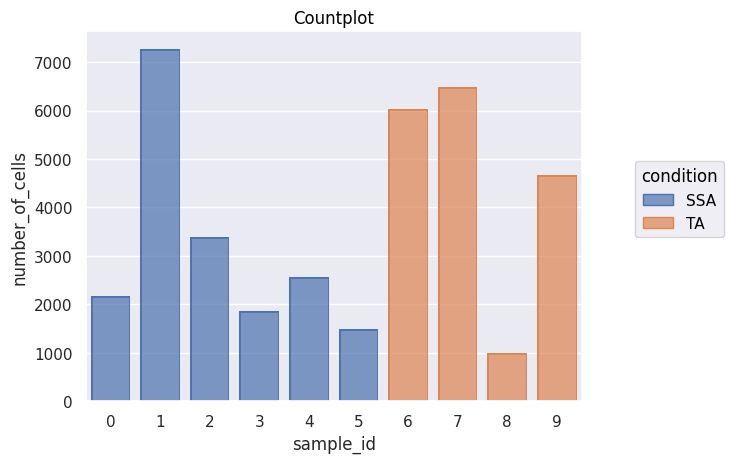

In [18]:
'''
Doing a single-cell data analysis in PalmettoBUG will be covered more in a different notebook -- but for this notebook I will generate a countplot just to show that
we have successfully entered the Analysis portion of the software!
'''
fig = Analysis_experiment.plot_cell_counts(group_by = "sample_id", color_by = "condition", filename = "countplot.png")
fig